In [1]:
import rebound
print(rebound.__build__)
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %matplotlib inline
    import matplotlib.pyplot as plt
from ctypes import cdll, byref
cgr = cdll.LoadLibrary("gr_force.so")

Oct 17 2016 14:08:45


In [2]:
def setup(sim):
    sim.additional_forces=cgr.gr_force
def gr_potential(sim):
    source = sim.particles[0]
    mu = sim.G*source.m
    prefac = 3.*mu*mu/1.0130251e+08
    grpot = 0.
    for i in range(1,sim.N):
        pi = sim.particles[i] - source
        r2 = pi.x*pi.x + pi.y*pi.y + pi.z*pi.z
        grpot -= prefac*sim.particles[i].m/r2
    return grpot

In [3]:
sa = rebound.SimulationArchive("restart_0013.bin",setup=setup)

1 loop, best of 1: 1.91 s per loop


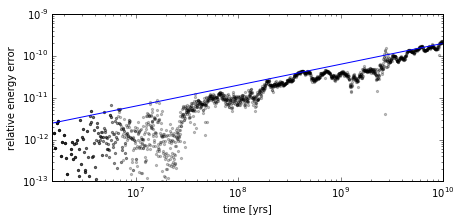

In [21]:
%%timeit -n1 -r1 
fig = plt.figure(figsize=(7, 3)) 
ax = plt.subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-13,1e-9])
sim0 = sa.getSimulation(0.)
e0 = sim0.calculate_energy()+gr_potential(sim0)

if False:
    times = np.logspace(3., 8, 2500)
    data = np.zeros((2,len(times)))
    for j, sim in enumerate(sa.getSimulations(times, mode='close')):
        data[0][j] = sim.t
        data[1][j] = np.abs((e0-sim.calculate_energy()-gr_potential(sim))/e0)    
    ax.scatter(data[0]/(2.*np.pi), data[1],marker=".");
    ax.set_xlim([data[0][0]/(2.*np.pi),sa.tmax/(2.*np.pi)])    

times = np.logspace(7., np.log10(sa.tmax), 2000)
data = np.zeros((2,len(times)))
for j, sim in enumerate(sa.getSimulations(times)):
    data[0][j] = sim.t
    data[1][j] = np.abs((e0-sim.calculate_energy()-gr_potential(sim))/e0)
    
ax.set_xlim([data[0][0]/(2.*np.pi),sa.tmax/(2.*np.pi)])        
ax.set_xlabel("time [yrs]")
ax.set_ylabel("relative energy error")
ax.scatter(data[0]/(2.*np.pi), data[1],marker=".",color="black",alpha=0.24);
ax.plot([1e5,1e10],2e-10*np.sqrt([1e5,1e10])/1e5);
plt.savefig("f_energy.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [5]:
def moving_average(a, n=3) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

1 loop, best of 1: 2.32 s per loop


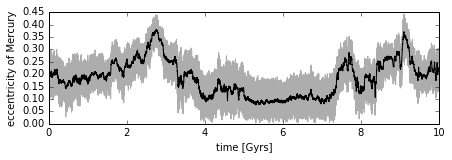

In [22]:
%%timeit -n1 -r1 
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
times = np.linspace(sa.tmin, sa.tmax, 20000)
data = np.zeros((2,len(times)))
le =0
for i, sim in enumerate(sa.getSimulations(times)):
    data[0][i] = sim.t/2/np.pi/1e9
    data[1][i] = sim.particles[1].e
ax.set_xlim([0,data[0][-1]])            
n=30
ax.set_xlabel("time [Gyrs]")
ax.set_ylabel("eccentricity of Mercury")
ax.plot(data[0], data[1], color="black",alpha=0.32);
ax.plot(data[0][n//2:-n//2+1], moving_average(data[1],n=n),color="black");
plt.savefig("f_eccentricity.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [19]:
%timeit -n1 -r1 print(5)

5
1 loop, best of 1: 26.3 µs per loop


In [13]:
def thread_init(*rest):
    global sat
    sat = rebound.SimulationArchive("restart_0013.bin",setup=setup)
pool = rebound.InterruptiblePool(initializer=thread_init) 

In [9]:
def analyze(t):
    sim = sat.getSimulation(t,mode="close")
    return [sim.t/2/np.pi,sim.particles[3].e]

1 loop, best of 1: 41.2 s per loop


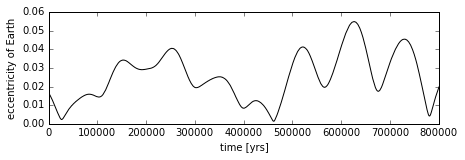

In [23]:
%%timeit -n1 -r1 
times = np.linspace(0.1, 801e3*2.*np.pi, 1000)
res = np.array(pool.map(analyze,times))
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
ax.set_xlim([0,res[-1][0]])            
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity of Earth")
ax.plot(res[:,0], res[:,1], color="black");
plt.savefig("f_eccentricity_earth.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

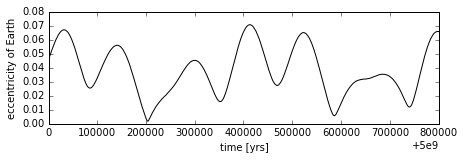

In [16]:
times = np.linspace(5e9*2*np.pi+0., 5e9*2*np.pi+801e3*2.*np.pi, 1000)
res = np.array(pool.map(analyze,times))
fig = plt.figure(figsize=(7, 2)) 
ax = plt.subplot(111)
ax.set_xlim([res[1][0],res[-1][0]])            
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity of Earth")
ax.plot(res[:,0], res[:,1], color="black");
plt.savefig("f_eccentricity_earth5.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

In [11]:
pool.close()